<a href="https://colab.research.google.com/github/SCS-Technology-and-Innovation/DACS/blob/main/DTDA/antennas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eliminate the interference
## Frequency-assignment to wireless antennas

In the last module we worked with the delivery territories of pizza restaurants. Now, assume we are worrying about cellphone coverage instead. Again, we will simplify and assume a square town. We will place towers of a known, fixed range one by one and study the percentage of the town that has coverage. 

We do *not* want to place to antennas very close to one another, so let's first define a subroutine to determine how if a candidate position is too close to the already preseny antennas. To achieve thie, we make use of our old friend, the Euclidean distance.

In [38]:
from math import sqrt # square root already exists as a subroutine in a library for math stuff

def distance(p1, p2):
  (r1, c1) = p1 # access row and column
  (r2, c2) = p2
  dr = r1 - r2 # subtract to compute how far apart they are
  dc = c1 - c2
  return sqrt(dr**2 + dc**2) 

# is the minimum distance between the existing antennas okay, if any, and the candidate position
def farEnough(candidate, existing, threshold):
  if len(existing) == 0: # no existing antennas
    return True # it is not too close since there is nothing there
  nearest = min( [ distance(candidate, antenna) for antenna in existing ] ) # distance to closest
  return nearest > threshold # distance to closest is larger than threshold

Let's think like engineers and stop worring about pixels. The town will be one unit wide and one unit long. Antenna positions will hence be values between zero and one. 

In [39]:
howMany = 12 # cellphone towers now instead of restaurants
range = 0.1 # how far does the tower reach (assume circular coverage)
margin = range / 2 # let's not place antennas too close to one another or to the edge of town

from random import random # this one generates pseudorandom values from zero to one

antennas = [] # empty list
while len(antennas) < howMany: # until the length reaches the desired value
  x = random()
  y = random()
  pos = (x, y) 
  if farEnough(pos, antennas, margin):
      antennas.append(pos)
antennas

[(0.7858662650411856, 0.5034957378760249),
 (0.4525101200283256, 0.4144031941126366),
 (0.0761458651636443, 0.3477744201829115),
 (0.31458116684520243, 0.907058559594315),
 (0.441161942012263, 0.5927758410622224),
 (0.22138498384554128, 0.2811438912302133),
 (0.6252344785208933, 0.14129031003748693),
 (0.19054922925073658, 0.4424024646464634),
 (0.8417596345432801, 0.8948605698441383),
 (0.03789824078333326, 0.250211184757397),
 (0.29261639279643314, 0.6441631444877611),
 (0.6185207334689798, 0.7382678892040259)]

It would still be nice to draw it, so we can use images like before. We just need to scale the decimal coordinates into pixel positions. Our (0, 0) will be the top left of the image and our (1, 1) will become the last pixel on the bottom right.

When drawing rectangles or ellipses with PIL, we need to speak of the top left corner and the bottom right corner of the *bounding box* of the thing we wish to draw. If the antenna is centered at a known pixel, we have to move half the desired with up in terms of the row and left in terms of the column to center a rectangle at that position. We will use a circle to display the range.

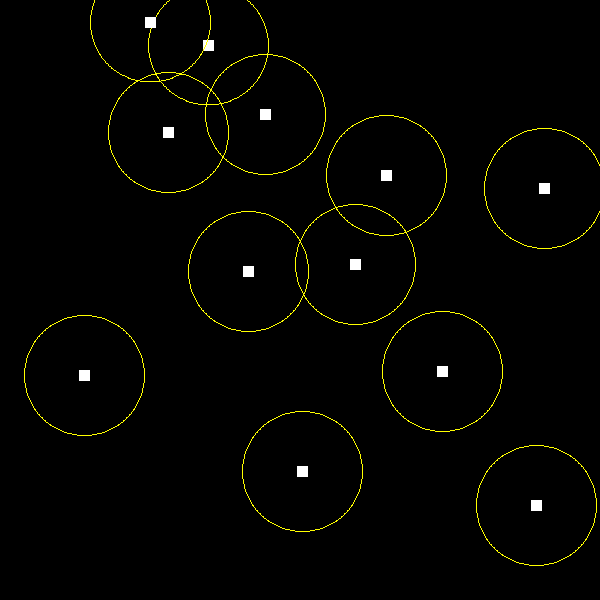

In [40]:
groundColor = (0, 0, 0) # black
antennaColor = (255, 255, 255) # white
rangeColor = (255, 255, 0) # yellow

size = 600 # make the image this many pixels wide and tall
rangeUnit = range * size
displayUnit = 5 # draw antennas as small squares that are twice this width

from PIL import Image, ImageDraw
town = Image.new('RGB', (size, size), groundColor)
canvas = ImageDraw.Draw(town) # we want to DRAW instead of alter pixels

for pos in antennas:
    (x, y) = pos
    col = size * x # let's make x the horizontal coordinate, meaning the pixel column
    row = size * y # let's make y the vertical coordinate, meaning the pixel row   

    # compute the bounding box for the rectangle that shows the antenna position
    antennaTopLeftRow = row - displayUnit
    antennaTopLeftColumn = col - displayUnit
    antennaBottomRightRow = row + displayUnit
    antennaBottomRightColumn = col + displayUnit
    antennaBoundingBox = (antennaTopLeftRow, antennaTopLeftColumn, antennaBottomRightRow, antennaBottomRightColumn)
    canvas.rectangle(antennaBoundingBox, fill = antennaColor) 

    # compute the bounding box for the circle that shows its range
    rtr = row - rangeUnit
    rtc = col - rangeUnit
    rbr = row + rangeUnit
    rbc = col + rangeUnit
    rBB = (rtr, rtc, rbr, rbc)
    canvas.ellipse(rBB, outline = rangeColor) 

display(town) # show 

How could we go about computing the total coverage? We cannot just add up the areas of the circles since some of them will overlap. Let's be clever and make use of the fact that we are drawing the whole thing. If instead of drawing the borders of the coverage ranges, we just fill the circles with yellow, we can then ask the image how many black pixels it has. 

Then, if we *normalize* by the total number of pixels, we get the proportion of the image that is black. This multiplied by a hundred gives us a percentage.

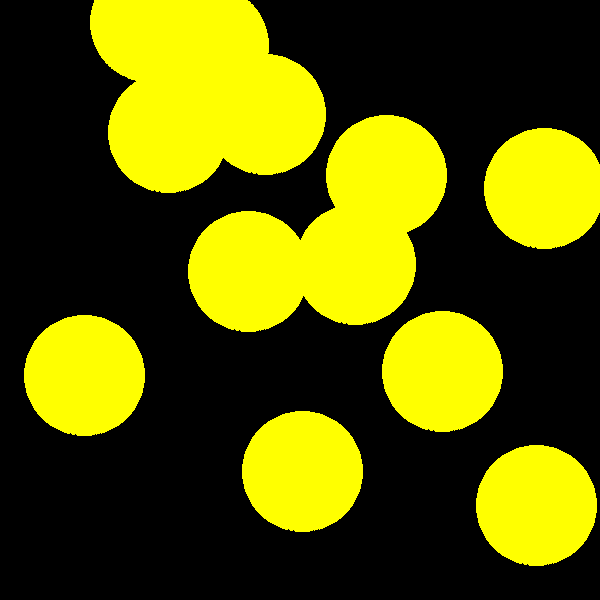

236255 uncovered pixels
65.6 percent uncovered


In [41]:
town = Image.new('RGB', (size, size), groundColor)
canvas = ImageDraw.Draw(town) # we want to DRAW instead of alter pixels

for pos in antennas:
    (x, y) = pos
    col = size * x 
    row = size * y 
    rtr = row - rangeUnit
    rtc = col - rangeUnit
    rbr = row + rangeUnit
    rbc = col + rangeUnit
    rBB = (rtr, rtc, rbr, rbc)
    canvas.ellipse(rBB, fill = rangeColor) # not outline anymore, use fill instead

display(town) # show 

total = size * size
uncovered = 0
for pixel in town.getdata():
    if pixel == groundColor:
        uncovered += 1
print(uncovered, 'uncovered pixels')
proportion = uncovered / total
percentage = 100 * proportion
print('{:.1f}'.format(percentage), 'percent uncovered')

This calculation sounds very much like a good subroutine for us to use whenever we need to compute the coverage as a number.

In [64]:
def coverage(image, background):
  width, height = image.size
  total = width * height
  uncovered = 0
  for pixel in image.getdata():
     if pixel == background:
         uncovered += 1
  return 1 - uncovered / total # the proportion COVERED by the NON-background pixels

100 * coverage(town, groundColor)

0.0

So, now we could keep adding antennas one by one until the whole zone has been covered. At the end, we could visualize them with just the positions and the outlines of the ranges to see the outcome.

First, let's improve our logic. The coverage is incomplete as long as at least some of the zone is uncovered. We do not really *need* to know the percentage, we just need to know if there are still places that are not covered.

In [53]:
def holes(image, background):
  width, height = image.size
  for pixel in image.getdata():
    if pixel == background:
        return True

antennas = [] # empty list
permitted = 20 # how many times to try at maximum when failing to find a position
attempts = permitted

# let's use an auxiliary image just to track the coverage
aux = Image.new('RGB', (size, size), groundColor)
cov = ImageDraw.Draw(aux) 
# and a second image that we actually want to SEE at the end
town = Image.new('RGB', (size, size), groundColor)
canvas = ImageDraw.Draw(town) 

while holes(aux, groundColor): # while there are still areas to cover
  x = random()
  y = random()
  pos = (x, y) 
  if farEnough(pos, antennas, margin): # add an antenna
      attempts = permitted
      antennas.append(pos)
      col = size * x 
      row = size * y 
      rtr = row - rangeUnit
      rtc = col - rangeUnit
      rbr = row + rangeUnit
      rbc = col + rangeUnit
      cov.ellipse((rtr, rtc, rbr, rbc), fill = rangeColor) 
      canvas.ellipse((rtr, rtc, rbr, rbc), outline = rangeColor) 
  else: # in case it was NOT far enough
      attempts -= 1 # one less attempt remains
      if attempts == 0:
          perc = 100 * coverage(aux, groundColor)
          print(f'Ran out of attempts, bailing out at a {perc} percent coverage')
          break

Ran out of attempts, bailing out at a 99.99666666666667 percent coverage


Let's look at the coverage in the auxiliary image.

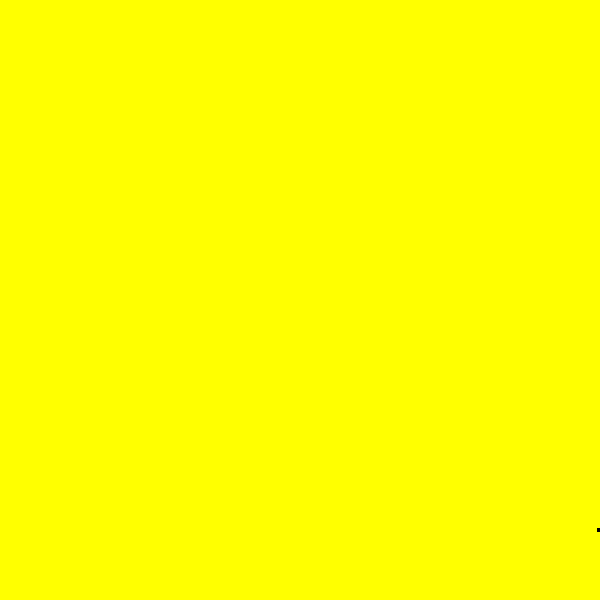

In [54]:
display(aux)

How about the antenna ranges?

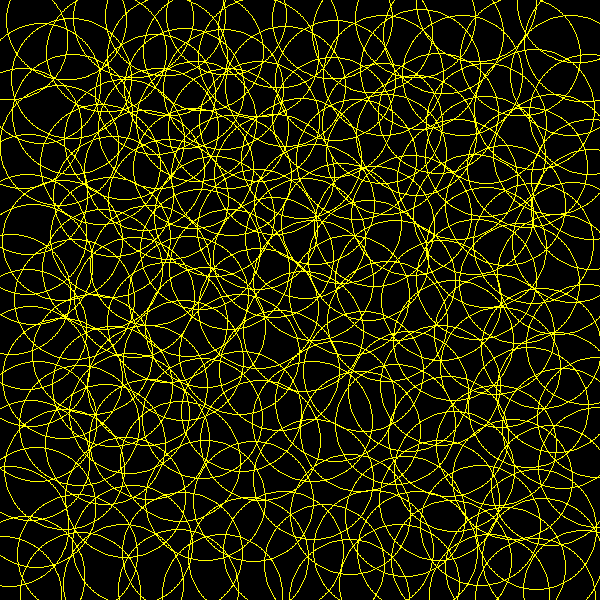

In [55]:
display(town)

Could we maybe save some money and get rid of some antennas without a significant loss of coverage? We could try removing antennas at random and then recompute everything but that sounds like a whole lot of repeating calculations with tons of auxiliary images. 

Instead, let's look at how much a new candidate antenna would *expand* the coverage and reject it if the contribution is insignificant. To determine the significance or lack thereof, we can look at the pixels that would fall within the range of the candidate antenna and see what proportion of those are *presently* uncovered. 

To make calculations simpler, we can just use the bounding box of the circle instead of the circle itself.

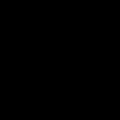

0.0


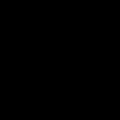

0.0


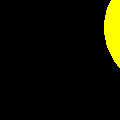

0.05743055555555554


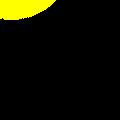

0.058541666666666714


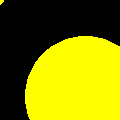

0.4892361111111111


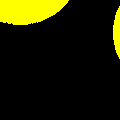

0.11131944444444442


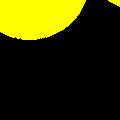

0.19458333333333333


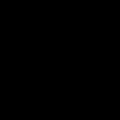

0.0


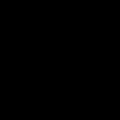

0.0


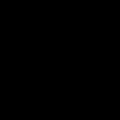

0.0


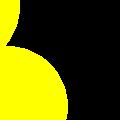

0.3451388888888889


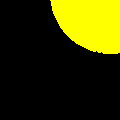

0.2073611111111111


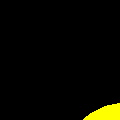

0.028680555555555598


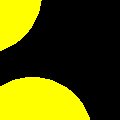

0.3206944444444444


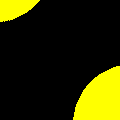

0.16902777777777778


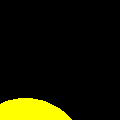

0.08506944444444442


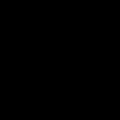

0.0


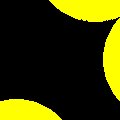

0.2210416666666667


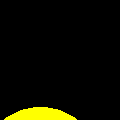

0.04576388888888894


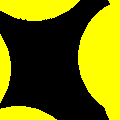

0.4203472222222222


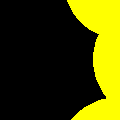

0.2586111111111111


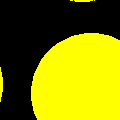

0.4822222222222222


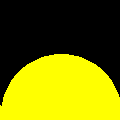

0.44381944444444443


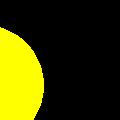

0.2278472222222222
Ran out of attempts, bailing out at a 64.50444444444445 percent coverage


In [69]:
antennas = [] # empty list
permitted = 20 # how many times to try at maximum when failing to find a position
attempts = permitted

# let's use an auxiliary image just to track the coverage
aux = Image.new('RGB', (size, size), groundColor)
cov = ImageDraw.Draw(aux) 

threshold = 0.5 # at most half covered at present
span = 1 - 2 * range # let's establish a margin, too

while holes(aux, groundColor): # while there are still areas to cover
  x = range + span * random()
  y = range + span * random()
  pos = (x, y) 
  col = size * x 
  row = size * y 
  bb = (row - rangeUnit, col - rangeUnit, row + rangeUnit, col + rangeUnit)
  zone = aux.crop(bb) # crop the subimage contained by the bounding box
  present = coverage(zone, groundColor) # what proportion is covered already
  if present < threshold: # we would cover enough new area
      display(zone) # let's see the area
      print(present)
      attempts = permitted
      antennas.append(pos)
      cov.ellipse(bb, fill = rangeColor) 
  else: # in case it was insignificant
      attempts -= 1 # one less attempt remains
      if attempts == 0:
          perc = 100 * coverage(aux, groundColor)
          print(f'Ran out of attempts, bailing out at a {perc} percent coverage')
          break